In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

import torchvision.models as models
from torchvision.models.resnet import ResNet152_Weights
from torchvision.models.vgg import VGG19_Weights
from torch.optim.lr_scheduler import OneCycleLR

In [8]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


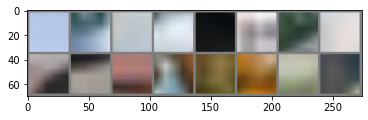

plane plane plane   car   car  frog   car plane   car   car  ship horse  deer  frog  deer   cat


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [3]:
print('Train set: ', len(trainset), 'Test set: ', len(testset))

Train set:  50000 Test set:  10000


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


### ResNet 152

In [10]:
rotation_transform = transforms.Compose([
#     transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.Resize(224),
#     transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=rotation_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)



Files already downloaded and verified


In [12]:
resnet152 = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)

#optional modify activation functions
# def replace_relu_with_prelu(module):
#     for name, child in module.named_children():
#         if isinstance(child, nn.ReLU):
#             setattr(module, name, nn.PReLU())
#         else:
#             replace_relu_with_prelu(child)

# replace_relu_with_prelu(resnet152)
# if isinstance(model.classifier[-1], nn.ReLU):
#     resnet152.classifier[-1] = nn.LeakyReLU(negative_slope=0.01)

# Freeze all layers except the last one
for param in resnet152.parameters():
    param.requires_grad = False
    
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 10)

# put to GPT
resnet152 = resnet152.to(device)

In [13]:
# seed = 23
num_epochs = 10
learning_rate = 0.001
betas = (0.95, 0.999)
# weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.(resnet152.fc.parameters(), lr=learning_rate) #, betas=betas, weight_decay=0.01)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(trainloader))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

optimizer = optim.Adam(resnet152.fc.parameters(), lr=learning_rate) # betas=betas, weight_decay=0.01
# optimizer = optim.SGD(resnet152.fc.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01, nesterov=True)

# Training
resnet_losses = []

total_step = len(trainloader)
for epoch in range(num_epochs):
    epoch_losses = []
    
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = resnet152(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
            
    scheduler.step()
    resnet_losses.append(np.mean(epoch_losses))

# Testing
resnet152.eval()  # Evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet152(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')

# Save the model checkpoint
# torch.save(resnet152.state_dict(), 'resnet152_cifar10.pth')


Epoch [1/10], Step [100/3125], Loss: 0.8522
Epoch [1/10], Step [200/3125], Loss: 0.6412
Epoch [1/10], Step [300/3125], Loss: 0.7380
Epoch [1/10], Step [400/3125], Loss: 0.9316
Epoch [1/10], Step [500/3125], Loss: 0.8772
Epoch [1/10], Step [600/3125], Loss: 0.8372
Epoch [1/10], Step [700/3125], Loss: 0.8603
Epoch [1/10], Step [800/3125], Loss: 0.4785
Epoch [1/10], Step [900/3125], Loss: 1.1012
Epoch [1/10], Step [1000/3125], Loss: 0.5130
Epoch [1/10], Step [1100/3125], Loss: 0.6434
Epoch [1/10], Step [1200/3125], Loss: 0.8403
Epoch [1/10], Step [1300/3125], Loss: 0.7115
Epoch [1/10], Step [1400/3125], Loss: 0.9473
Epoch [1/10], Step [1500/3125], Loss: 1.1980
Epoch [1/10], Step [1600/3125], Loss: 0.7251
Epoch [1/10], Step [1700/3125], Loss: 0.3571
Epoch [1/10], Step [1800/3125], Loss: 0.4525
Epoch [1/10], Step [1900/3125], Loss: 0.5641
Epoch [1/10], Step [2000/3125], Loss: 0.3728
Epoch [1/10], Step [2100/3125], Loss: 1.0985
Epoch [1/10], Step [2200/3125], Loss: 0.5854
Epoch [1/10], Step 

Epoch [6/10], Step [3000/3125], Loss: 0.9876
Epoch [6/10], Step [3100/3125], Loss: 0.7579
Epoch [7/10], Step [100/3125], Loss: 0.2642
Epoch [7/10], Step [200/3125], Loss: 0.6796
Epoch [7/10], Step [300/3125], Loss: 1.1042
Epoch [7/10], Step [400/3125], Loss: 0.2778
Epoch [7/10], Step [500/3125], Loss: 0.7987
Epoch [7/10], Step [600/3125], Loss: 0.8016
Epoch [7/10], Step [700/3125], Loss: 0.3062
Epoch [7/10], Step [800/3125], Loss: 0.6445
Epoch [7/10], Step [900/3125], Loss: 0.2851
Epoch [7/10], Step [1000/3125], Loss: 0.6287
Epoch [7/10], Step [1100/3125], Loss: 0.7007
Epoch [7/10], Step [1200/3125], Loss: 0.8135
Epoch [7/10], Step [1300/3125], Loss: 0.2381
Epoch [7/10], Step [1400/3125], Loss: 0.2413
Epoch [7/10], Step [1500/3125], Loss: 0.5572
Epoch [7/10], Step [1600/3125], Loss: 0.1129
Epoch [7/10], Step [1700/3125], Loss: 0.4462
Epoch [7/10], Step [1800/3125], Loss: 0.6511
Epoch [7/10], Step [1900/3125], Loss: 0.9506
Epoch [7/10], Step [2000/3125], Loss: 0.7220
Epoch [7/10], Step 

In [14]:
# resnet_baseline_losses = resnet_losses
# final resnet 86.19%, final vgg 89.02%
resnet_losses

[0.7238279910969734,
 0.6221887381052971,
 0.6054228113329411,
 0.5821911034023761,
 0.5791075113987922,
 0.5590450995665789,
 0.5441781113547087,
 0.5530270805722475,
 0.5347373846942186,
 0.5349937952697277]

### Get mean and std of the dataset

In [8]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

# Calculate the mean and std
data = next(iter(loader))[0]
mean = data.mean([0, 2, 3])
std = data.std([0, 2, 3])
print(f'Mean: {mean} \nStd: {std}')

Files already downloaded and verified
Mean: tensor([0.4914, 0.4822, 0.4465]) 
Std: tensor([0.2470, 0.2435, 0.2616])


### VGG 19

In [15]:
vgg19 = torchvision.models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

# optional activation function replacement
for i, layer in enumerate(vgg19.classifier):
    if isinstance(layer, nn.ReLU):
        vgg19.classifier[i] = nn.PReLU() # nn.LeakyReLU(negative_slope=0.01) nn.ELU(alpha=1.0)

        
# optional pooling function repalcement
# for i, layer in enumerate(vgg19.features):
#     if isinstance(layer, nn.MaxPool2d):
#         vgg19.features[i] = nn.AvgPool2d(kernel_size=2, stride=2)

for param in vgg19.features.parameters():
    param.requires_grad = False
    
num_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(num_features, 10)
vgg19.classifier[6].requires_grad = True

vgg19 = vgg19.to(device)

In [16]:
# vgg19.classifier
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.Resize(224),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomRotation(degrees=15),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [18]:
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(vgg19.parameters(), lr=learning_rate, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

training_losses = []

# Training
total_step = len(trainloader)
for epoch in range(num_epochs):
    epoch_losses = []
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = vgg19(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
            
    training_losses.append(np.mean(epoch_losses))
#     scheduler.step()

# Testing
vgg19.eval()  # Evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg19(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')

# Save the model checkpoint
# torch.save(vgg19.state_dict(), 'vgg19_cifar10.pth')

Epoch [1/10], Step [100/3125], Loss: 2.5955
Epoch [1/10], Step [200/3125], Loss: 0.9983
Epoch [1/10], Step [300/3125], Loss: 1.0207
Epoch [1/10], Step [400/3125], Loss: 1.4885
Epoch [1/10], Step [500/3125], Loss: 1.3867
Epoch [1/10], Step [600/3125], Loss: 1.5758
Epoch [1/10], Step [700/3125], Loss: 2.6675
Epoch [1/10], Step [800/3125], Loss: 1.0840
Epoch [1/10], Step [900/3125], Loss: 1.4123
Epoch [1/10], Step [1000/3125], Loss: 0.7701
Epoch [1/10], Step [1100/3125], Loss: 2.3544
Epoch [1/10], Step [1200/3125], Loss: 0.9257
Epoch [1/10], Step [1300/3125], Loss: 0.6308
Epoch [1/10], Step [1400/3125], Loss: 1.1004
Epoch [1/10], Step [1500/3125], Loss: 1.4668
Epoch [1/10], Step [1600/3125], Loss: 1.4097
Epoch [1/10], Step [1700/3125], Loss: 1.6043
Epoch [1/10], Step [1800/3125], Loss: 1.3535
Epoch [1/10], Step [1900/3125], Loss: 0.9595
Epoch [1/10], Step [2000/3125], Loss: 1.9041
Epoch [1/10], Step [2100/3125], Loss: 1.9414
Epoch [1/10], Step [2200/3125], Loss: 1.1449
Epoch [1/10], Step 

Epoch [6/10], Step [3000/3125], Loss: 0.5015
Epoch [6/10], Step [3100/3125], Loss: 2.0689
Epoch [7/10], Step [100/3125], Loss: 0.3788
Epoch [7/10], Step [200/3125], Loss: 1.1127
Epoch [7/10], Step [300/3125], Loss: 1.9951
Epoch [7/10], Step [400/3125], Loss: 0.2817
Epoch [7/10], Step [500/3125], Loss: 0.9390
Epoch [7/10], Step [600/3125], Loss: 0.6569
Epoch [7/10], Step [700/3125], Loss: 0.4299
Epoch [7/10], Step [800/3125], Loss: 0.4530
Epoch [7/10], Step [900/3125], Loss: 0.6623
Epoch [7/10], Step [1000/3125], Loss: 0.5594
Epoch [7/10], Step [1100/3125], Loss: 0.3129
Epoch [7/10], Step [1200/3125], Loss: 0.7002
Epoch [7/10], Step [1300/3125], Loss: 0.5757
Epoch [7/10], Step [1400/3125], Loss: 0.4330
Epoch [7/10], Step [1500/3125], Loss: 0.3408
Epoch [7/10], Step [1600/3125], Loss: 0.8295
Epoch [7/10], Step [1700/3125], Loss: 0.5358
Epoch [7/10], Step [1800/3125], Loss: 0.6447
Epoch [7/10], Step [1900/3125], Loss: 1.0708
Epoch [7/10], Step [2000/3125], Loss: 0.3272
Epoch [7/10], Step 

In [20]:
# training_losses = pd.read_csv('vgg_baseline.csv')
# training_losses = [i for i in training_losses['0']]
df = pd.DataFrame(training_losses)
df.to_csv('baseline_vgg.csv')

In [63]:
resnet_losses

[0.8885249836444855,
 0.6830758966445923,
 0.6494786764621735,
 0.6314742062568665,
 0.611768999004364,
 0.6018844368696212,
 0.5916703253746033,
 0.5850675179481506,
 0.5817040109157562,
 0.5696174758434296]

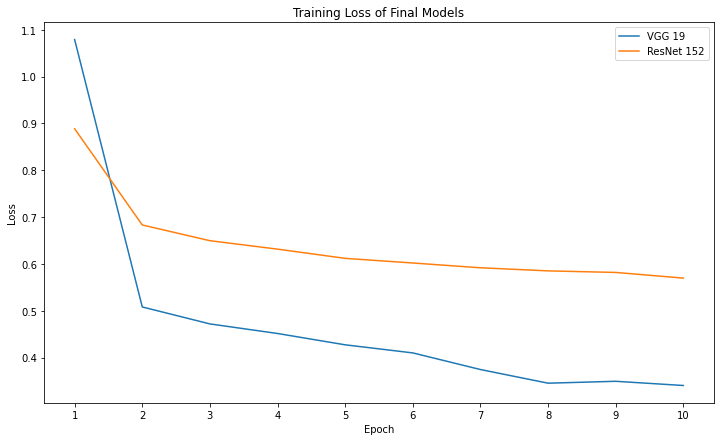

In [64]:
# plots
plt.figure(figsize=(12, 7))
plt.plot(range(1, num_epochs+1), training_losses, label='VGG 19')
plt.plot(range(1, num_epochs+1), resnet_losses, label='ResNet 152')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.title('Training Loss of Baseline Models')
plt.legend()
plt.savefig('final_model_loss_plot.png')
plt.show()

In [24]:
import pandas as pd
pd.DataFrame(training_losses).to_csv('vgg_baseline.csv')
# .to_csv('vgg_baseline.txt')

#### VGG (batch size of 64)
1. baseline without transformations: 85.82%
2. baseline with transformations: 82.99%
3. with RandomHorizontalFlip(): 86.89%
4. with ColorJitter: 87.24%
5. with 15 RandomRotation: 87.53%, 87.3%


- fresh start up till transformations 4: 83.4%, 82.99%
- fresh start up till transformations 4 leaky relu: 84.08%
- fresh start up till transformations 4 PRelu: 84.99%
- fresh start up till transformations 4 ELU: 82.73%


- no transformations with PRelu & repalcement of avgpooling: 82.72% --> use default maxpooling
- no transformations with PRelu & lr schedular: 85.24%


- PRelu with ColorJitter: 85.7%
- PRelu with ColorJitter & RandomRotation: 83.06%, only randomRotation: 84.64% --> don't use this
- PRelu with ColorJitter & RandomHorizontalFlip: 87.43%
- PRelu with ColorJitter & RandomHorizontalFlip & lr schedular: 87.13% --> even tho lr improves baseline, combined with best transformations, it fails to surpass performance
- PRelu with ColorJitter & RandomHorizontalFlip & mean std normalization: 87.59%
- PRelu with ColorJitter & RandomHorizontalFlip & mean std normalization & lr schedular: 89.02%
- PRelu with ColorJitter & RandomHorizontalFlip & mean std normalization & lr schedular & batch size 100: 88.26
- PRelu with ColorJitter & RandomHorizontalFlip & mean std normalization & lr schedular & adamW: 88.16%

### Load previously saved checkpoint

In [2]:
vgg19 = torchvision.models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

# Freeze the features layers
for param in vgg19.features.parameters():
    param.requires_grad = False

num_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(num_features, 10)  # CIFAR-10 has 10 classes

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19 = vgg19.to(device)

In [ ]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, vgg19.parameters()), lr=0.001, momentum=0.9)

# Load the checkpoint
checkpoint = torch.load('vgg19_cifar10.pth', map_location=device)

# Load the model and optimizer states
vgg19.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# If the epoch was saved, load it too
start_epoch = checkpoint.get('epoch', 0) + 1

### Plots

In [6]:
vgg_baseline = pd.read_csv('baseline_vgg.csv')['0']
vgg_baseline = [i for i in vgg_baseline]
vgg_baseline

[1.3038784056520465,
 1.0758894720566272,
 0.9518372758090496,
 0.8822371662020684,
 0.8218624823260308,
 0.7593344508105516,
 0.7310994443321228,
 0.693197892627716,
 0.6474720215316117,
 0.6217293811646104]

In [17]:
resnet_losses

[0.7238279910969734,
 0.6221887381052971,
 0.6054228113329411,
 0.5821911034023761,
 0.5791075113987922,
 0.5590450995665789,
 0.5441781113547087,
 0.5530270805722475,
 0.5347373846942186,
 0.5349937952697277]

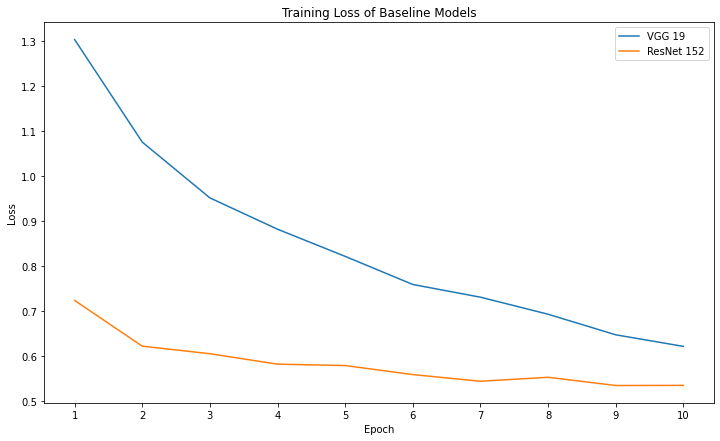

In [19]:
plt.figure(figsize=(12, 7))
plt.plot(range(1, num_epochs+1), vgg_baseline, label='VGG 19')
plt.plot(range(1, num_epochs+1), resnet_losses, label='ResNet 152')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.title('Training Loss of Baseline Models')
plt.legend()
# plt.savefig('baseline_loss_plot.png')
plt.show()

No handles with labels found to put in legend.


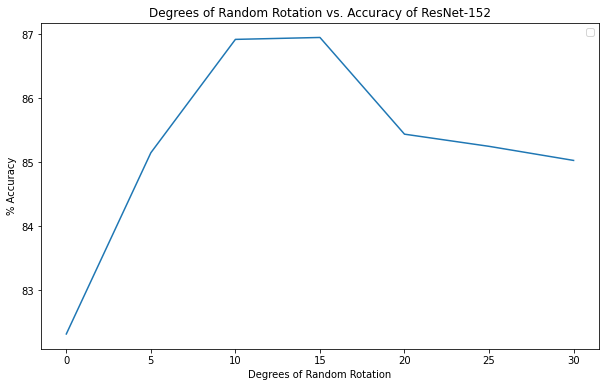

In [9]:
# Rotation 5 degrees: 85.15%
# Rotation 10: 86.92%
# Rotation 15: 86.95%
# Rotation 20: 85.44%
# Rotation 25: 85.25%
# Rotation 30: 85.03%
degrees = [i for i in range(0, 31, 5)]
rotation = [82.32, 85.15, 86.92, 86.95, 85.44, 85.25, 85.03]
plt.figure(figsize=(10, 6))
plt.plot(degrees, rotation)
plt.xlabel('Degrees of Random Rotation')
plt.ylabel('% Accuracy')
plt.title('Degrees of Random Rotation vs. Accuracy of ResNet-152')
plt.legend()
plt.savefig('rotation_plot.png')

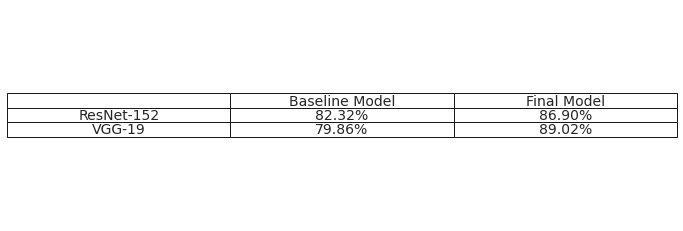

In [15]:
table = pd.DataFrame({
    '': ['ResNet-152', 'VGG-19'],
    'Baseline Model': ['82.32%', '79.86%'],
    'Final Model': ['86.90%', '89.02%']
})

fig, ax = plt.subplots(figsize=(10, 4))

# Plotting the table with bigger cells
table_plot = ax.table(cellText=table.values, colLabels=table.columns, loc='center', cellLoc='center')
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(14)
table_plot.scale(1.2, 1.2)

# Hide axes
ax.axis('off')

# Save the figure
plt.savefig('accuracy_table.png')